---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. You should NOT use Neural Network related classifiers (e.g., MLPClassifier) in this question. 

* Try to avoid global variables. If you have other functions besides blight_model, you should move those functions inside the scope of blight_model.

* Refer to the pinned threads in Week 4's discussion forum when there is something you could not figure it out.

In [19]:


def blight_model():
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import OrdinalEncoder
    from sklearn.model_selection import train_test_split
    from sklearn.dummy import DummyClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score, precision_score, recall_score
    from sklearn.metrics import roc_curve, roc_auc_score
    
    # Your code here
    
    #Importing data from all files
    train = pd.read_csv('train.csv', sep=',', header=0, engine='python')
    addresses = pd.read_csv('addresses.csv')
    lat_lons = pd.read_csv('latlons.csv')
    #test = pd.read_csv('test.csv', sep=',', header=0, engine='python')
    
    #Removing rows with compliance = null
    train = train[train.compliance.notnull()]
    
    #dropping features that are either not in test set or are linear combination of other features
    train.drop(columns=['payment_amount','payment_date','payment_status','balance_due','collection_status',
                        'compliance_detail','violation_zip_code'], inplace=True)
    #test.drop(columns=['violation_zip_code'])
    
    #Merging tickets with address
    data_with_address = train.merge(addresses, how='inner', on='ticket_id')
    #test_data_with_address = test.merge(addresses, how='inner', on='ticket_id')
    
    #Merging address with latitude and longitude
    data_with_lat_lons = data_with_address.merge(lat_lons, how='inner', on='address')
    #test_data_with_lat_lons = test_data_with_address.merge(lat_lons, how='inner', on='address')
    
    
    #Formatting data for feeding to learning algorithms
    
    #Filling Null values 
    data_with_lat_lons[['violator_name','mailing_address_str_name','zip_code','city','ticket_issued_date', 
                        'hearing_date']] = data_with_lat_lons[['violator_name','mailing_address_str_name',
                                                               'zip_code','city',
                                                              'ticket_issued_date',
                                                              'hearing_date']].fillna('A')
    
    #test_data_with_lat_lons[['violator_name','mailing_address_str_name','zip_code','city','ticket_issued_date', 
     #                       'hearing_date']] = test_data_with_lat_lons[['violator_name','mailing_address_str_name',
      #                                                              'zip_code','city',
       #                                                             'ticket_issued_date',
        #                                                            'hearing_date']].fillna('A')
    data_with_lat_lons[['mailing_address_str_number',
                       'lat','lon']] = data_with_lat_lons[['mailing_address_str_number',
                                                           'lat','lon']].fillna(0)
    #test_data_with_lat_lons[['mailing_address_str_number',
     #                        'lat','lon']] = test_data_with_lat_lons[['mailing_address_str_number',
      #                                                               'lat','lon']].fillna(0)
    
    #Creating training and test set from only relevant features selected through Decision Tree feature importance  
    training_set = data_with_lat_lons[['agency_name', 'inspector_name', 'violator_name', 'lat', 'lon', 
                                       'violation_street_number', 'violation_street_name', 
                                       'mailing_address_str_name', 'city','zip_code',
                                       'ticket_issued_date', 'hearing_date',
                                       'violation_code', 'disposition',
                                       'late_fee', 'discount_amount', 'judgment_amount',
                                       'compliance']]
    
    #test_set = test_data_with_lat_lons[['agency_name', 'inspector_name', 'violator_name', 'lat', 'lon', 
     #                                  'violation_street_number', 'violation_street_name',
      #                                  'mailing_address_str_name', 'city', 'zip_code',
       #                                'ticket_issued_date', 'hearing_date',
        #                               'violation_code', 'disposition',
         #                              'late_fee', 'discount_amount', 'judgment_amount']]
    
    
    #Converting training and test sets into arrays to feed to encoder
    X_train = training_set.iloc[:,0:17]
    X_train = np.array(X_train)
    y_train = np.array(training_set['compliance'])
    
    #X_test = np.array(test_set)
    
    #Encoding categorical data in both training and test set
    encoder = OrdinalEncoder()
    #encoder = OneHotEncoder(sparse=False)
    X_train = encoder.fit_transform(X_train)
    #X_test = encoder.fit_transform(X_test)
    
    #To Check Imbalance in the data
    #non_zeros = np.count_nonzero(y_train)
    #percent_non_zero = non_zeros/len(y_train)
    
    #Splitting the training set into train test split
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=0)
    
    #Fitting Dummy Classifier
    #dummy_clf = DummyClassifier(strategy='stratified').fit(X_train,y_train)
    #dummy_score = dummy_clf.score(X_test,y_test)
    
    #Fitting Decision Tree Classifier
    dt_classifier = DecisionTreeClassifier(random_state=0, max_depth=12).fit(X_train,y_train)
    #y_dt_predict = dt_classifier.predict(X_test)
    #train_accuracy_dt = accuracy_score(y_train,dt_classifier.predict(X_train))
    #test_accuracy_dt = accuracy_score(y_test,y_dt_predict)
    #precision_dt = precision_score(y_test,y_dt_predict)
    #recall_dt = recall_score(y_test,y_dt_predict)
    dt_classifier_proba = dt_classifier.predict_proba(X_test)
    fpr, tpr, threshold = roc_curve(y_test,dt_classifier_proba[:,1])
    auc_roc_score_dt = roc_auc_score(y_test,dt_classifier_proba[:,1])
    plt.plot(fpr,tpr,'-b', label='Decision Tree')
    
    #Fitting Random Forest Classifier
    rf_classifier = RandomForestClassifier(random_state=0,max_depth=20).fit(X_train,y_train)
    #y_rf_predict = rf_classifier.predict(X_test)
    
    #Predicting probabilities of classes in test set
    #y_rf_predict_proba = rf_classifier.predict_proba(X_test)
    #compliance = pd.Series(y_rf_predict_proba[:,1], index=test['ticket_id'])
    

    #train_accuracy_rf = accuracy_score(y_train,rf_classifier.predict(X_train))
    #test_accuracy_rf = accuracy_score(y_test,y_rf_predict)
    #precision_rf = precision_score(y_test,y_rf_predict)
    #recall_rf = recall_score(y_test,y_rf_predict)
    rf_classifier_proba = rf_classifier.predict_proba(X_test)
    fpr, tpr, threshold = roc_curve(y_test,rf_classifier_proba[:,1])
    auc_roc_score_rf = roc_auc_score(y_test,rf_classifier_proba[:,1])
    plt.plot(fpr,tpr,'-r', label='Random Forest')
    
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc = 'upper left')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

    return print('AUCROC Score of Decision Tree Classifier: ', auc_roc_score_dt,
                 '\n',
                'AUCROC Score of Randomforest Classifier: ', auc_roc_score_rf)#compliance #Your answer here

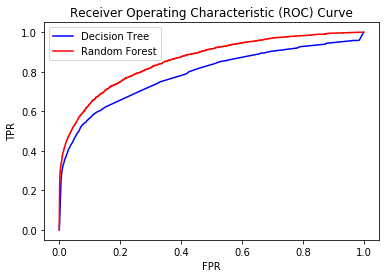

AUCROC Score of Decision Tree Classifier:  0.7871220137760297 
 AUCROC Score of Randomforest Classifier:  0.8600024611695312


In [20]:
blight_model()